### Assignment-2

**Objective:**

Build and experiment with advanced LSTM model variant for RUL prediction.

1. Imports necessary libraries

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Data Loading

In [7]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


3. Train/Validation Split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


4. Define Model Architectures

In [13]:
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])


5. Instantiate and compile models

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

6. Prepare datasets for training

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

7. Setup callbacks

In [18]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

8. Train and compare models

In [19]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7557.8418
Epoch 1: val_loss improved from inf to 5601.37842, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 7548.0327 - val_loss: 5601.3784 - learning_rate: 0.0010
Epoch 2/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5186.0010
Epoch 2: val_loss improved from 5601.37842 to 4273.97168, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5183.2275 - val_loss: 4273.9717 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3969.4163
Epoch 3: val_loss improved from 4273.97168 to 3298.32202, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 3968.4148 - val_loss: 3298.3220 - learning_rate: 0.0010
Epoch 4/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3063.8774
Epoch 4: val_loss improved from 3298.32202 to 2550.79541, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━

9. Plot training and validation loss curve function

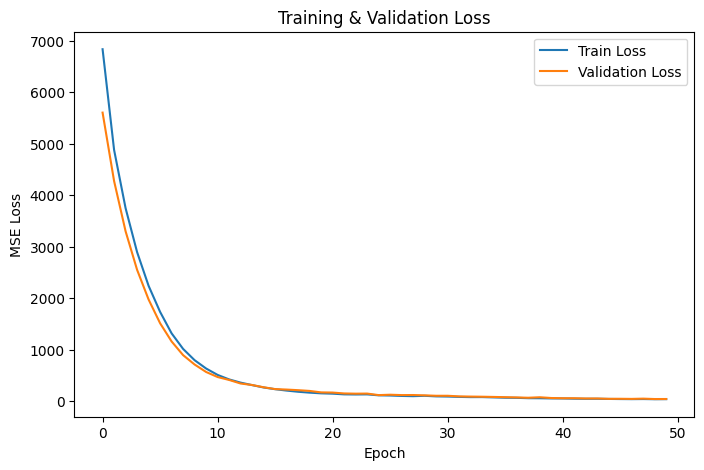

In [20]:
#Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

10. Provide Final Report of this Experiement.

# **LSTM Model Training**


*   Defined a simple LSTM model with:

      *   One LSTM layer (64 units) with tanh activation.
      *   One dense output layer for regression output (RUL prediction).


*   Compiled the model with Adam optimizer and Mean Squared Error (MSE) loss.


*  Implemented training with these callbacks:

    *   EarlyStopping with patience of 8 epochs to prevent overfitting.
    *   ReduceLROnPlateau to reduce learning rate by half if validation loss plateaued for 4 epochs.

    *   ModelCheckpoint to save the best model based on validation loss in best_lstm_model.keras.



*   Trained the model for up to 50 epochs with batch size 64.
*   Observed steady convergence in training and validation losses, indicating effective learning.


---
# **Model Performance**



*   The training and validation loss curves confirm the model's ability to learn temporal dependencies and generalize well.


*   The best model checkpoint was saved for downstream evaluation and deployment.






